El objetivo de este notebook es crear un recomendador muy sencillo, que sirva de línea base y con el que poder comparar

In [1]:
from typing import Dict, List, Tuple, Union, Any, Optional

import os
import sys
print("Python version", sys.version)

import numpy as np
import pandas as pd
import itertools as it

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.autonotebook import tqdm

from src.datasets import daocensus_text, to_microsoft
from src.model_selection import timeIntervalSplit, timeFreqSplitCurrent
from src.utils import notebooks as nbutils

sns.set_theme()

Python version 3.9.18 (main, Oct 24 2023, 09:18:18) 
[GCC 11.4.0]


/tmp/ipykernel_338452/804985562.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Dataset splits config
N_SPLITS: int = 10

# Always 0, just skip the first rows in the CSV to compare with others
SKIP_SPLIT: int = 0

# the second way of making splits
SPLITS_FREQ: str = 'W-THU'
SPLITS_NORMALIZE: bool = True
LAST_SPLITS: int = 10 # Only used to generate baseline graph

K_RECOMMENDATIONS: List[int] = [5, 10, 15]

ORG_NAME: str = 'Decentraland'
ORG_PLATFORM: str = 'snapshot'
USE_ORG_NAMES: bool = True

CUTOFF_DATE_STR = ... # Not used

In [3]:
# Parameters
ORG_NAME = "Index Coop"
ORG_PLATFORM = "snapshot"
SPLITS_FREQ = "W-THU"
SPLITS_NORMALIZE = True
LAST_SPLITS = 10
USE_ORG_NAMES = True
EXECUTION_ID = "2024-03-01 21:00"
CUTOFF_DATE_STR = "2023-05-12"


# Load data

In [4]:
# dfv, dfp = daocensus.get("./data/daos-census", ORG_NAME, 'snapshot')
# dfptime = pd.read_csv('./snapshot_proposals.csv')[['proposal_id', 'title', 'description', 'start', 'end']]
# dfp = dfp.merge(dfptime, how='left', left_on='platform_proposal', right_on='proposal_id')
# dfp[['start', 'end']] = dfp[['start', 'end']].astype('datetime64')

dfv, dfp = daocensus_text.get("./data/daos-census-text", ORG_NAME, ORG_PLATFORM, use_org_names=USE_ORG_NAMES)
print(dfv.info())
print(dfp.info())

Warning, removing 24031 votes without proposal
<class 'pandas.core.frame.DataFrame'>
Int64Index: 24031 entries, 0 to 24030
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   platform       24031 non-null  object        
 1   name           24031 non-null  object        
 2   id             24031 non-null  object        
 3   proposal       24031 non-null  category      
 4   deployment     24031 non-null  object        
 5   platform_vote  24031 non-null  object        
 6   voter          24031 non-null  category      
 7   date           24031 non-null  datetime64[ns]
 8   choice         24031 non-null  object        
 9   weight         24031 non-null  float64       
dtypes: category(2), datetime64[ns](1), float64(1), object(6)
memory usage: 1.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 874 entries, 0 to 1002
Data columns (total 13 columns):
 #   Column               Non-Null Co

In [5]:
df = to_microsoft(dfv)
df.head()

,userID,itemID,timestamp,rating
0,0x97a1ca841b4792068932d4224681f6f6fa22c549,ff818a67-b9a9-5752-a6fc-775ebbaf5495,2023-07-13 00:13:46,1
1,0x8d5237037a590a2db531f3cfb8f42605cf306f34,68ae729a-bcb2-525a-b696-28409badb9fa,2022-11-08 14:56:08,1
2,0x03dce5fa9e968ffb6b64e781d11422228c86c368,68ae729a-bcb2-525a-b696-28409badb9fa,2022-11-08 10:08:06,1
3,0x03f623de8464124feff439a6bdb3f9793b6ed34c,68ae729a-bcb2-525a-b696-28409badb9fa,2022-11-08 10:04:30,1
4,0xff03658e92a9162fe78bd7e8bc5d0aa45739e8bb,68ae729a-bcb2-525a-b696-28409badb9fa,2022-11-08 08:31:50,1


# Exploring data

## How much time does each proposal take

Most proposals take a week, but there are a few that take less than 7 days.

count                          874
mean     2 days 20:51:00.808924485
std      1 days 12:19:20.021577041
min                0 days 10:00:00
25%                2 days 00:00:00
50%         2 days 12:21:20.500000
75%                3 days 00:00:00
max               19 days 23:59:31
dtype: object

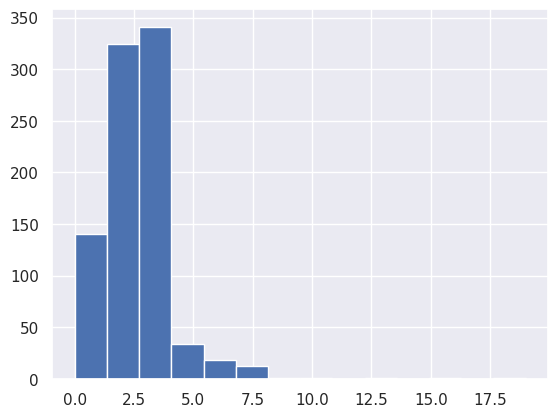

In [6]:
delta = dfp['end'] - dfp['start']
delta.dt.days.hist(bins=14)
delta.describe()

### Just for MetaCartel, avg proposal length in time

<Axes: xlabel='date'>

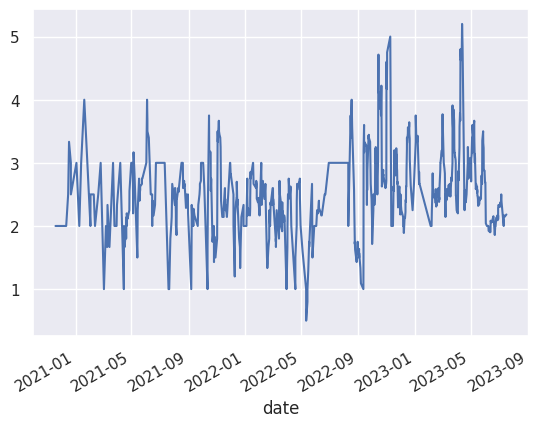

In [7]:
# TODO
_delta = dfp.assign(delta=delta).set_index('date').sort_index()['delta'].dt.days
_delta.rolling('7D').mean().plot()

## What day or the week are proposals created

Monday       250
Tuesday      173
Wednesday    154
Thursday     118
Friday       101
Saturday      46
Sunday        32
Name: start, dtype: int64

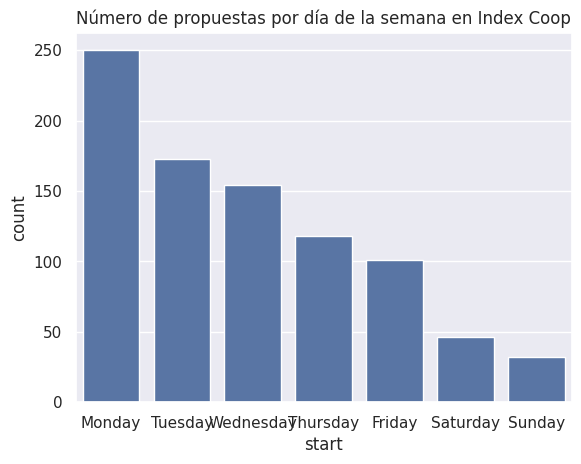

In [8]:
import seaborn as sns

ax = sns.countplot(x=dfp['start'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
dfp['start'].dt.day_name().value_counts()

Tuesday      6455
Wednesday    4932
Thursday     4115
Monday       3095
Friday       2538
Saturday     1823
Sunday       1073
Name: date, dtype: int64

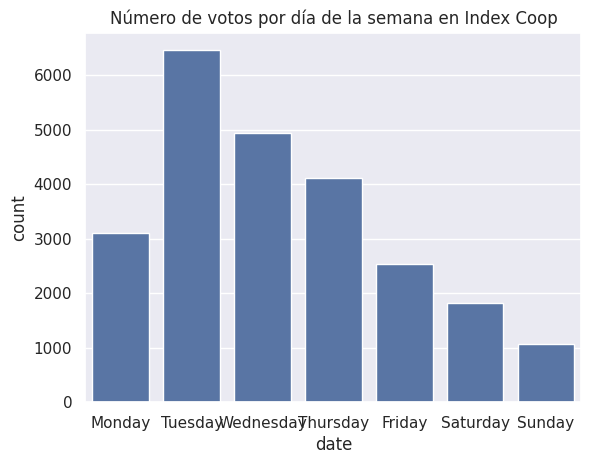

In [9]:
ax = sns.countplot(x=dfv['date'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_title(f'Número de votos por día de la semana en {ORG_NAME}')
dfv['date'].dt.day_name().value_counts()

## Ahora en porcentaje acumulado

<Axes: xlabel='rel_day', ylabel='proposals'>

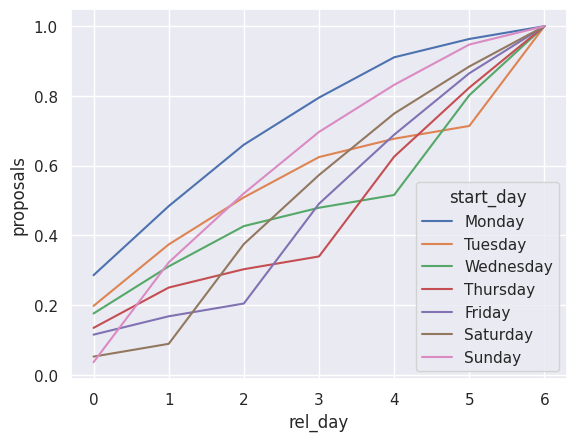

In [10]:
# ax = sns.countplot(x=dfp['start'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
# dfp['start'].dt.day_name().value_counts()

start_from = 2

vc = dfp['start'].dt.day_name().value_counts()
vc = vc / vc.sum()
series = []
for i, d in enumerate(vc.index):
    newindex = vc.index[i:].union(vc.index[:i], sort=False)
    assert len(newindex) == 7
    assert newindex[0] == d
    
    s = vc.reindex(newindex) \
        .cumsum() \
        .to_frame(name='proposals') \
        .reset_index().rename(columns={'index': 'day'}) \
        .reset_index().rename(columns={'index': 'rel_day'})
    s['start_day'] = d
    series.append(s)

sns.lineplot(pd.concat(series), x='rel_day', y='proposals', hue='start_day')

### Same with votes

<Axes: xlabel='rel_day', ylabel='votes'>

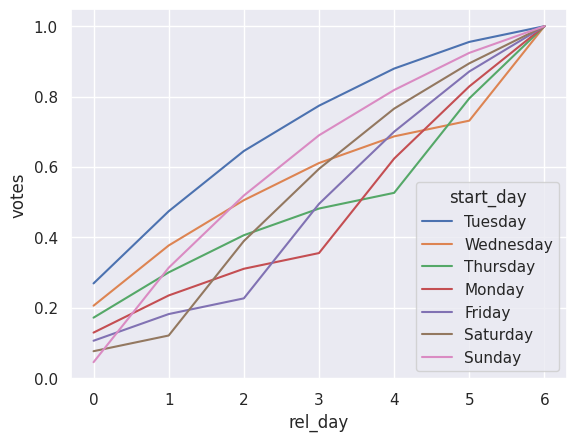

In [11]:
# ax = sns.countplot(x=dfp['start'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
# dfp['start'].dt.day_name().value_counts()

start_from = 2

vc = dfv['date'].dt.day_name().value_counts()
vc = vc / vc.sum()
series = []
for i, d in enumerate(vc.index):
    newindex = vc.index[i:].union(vc.index[:i], sort=False)
    assert len(newindex) == 7
    assert newindex[0] == d
    
    s = vc.reindex(newindex) \
        .cumsum() \
        .to_frame(name='votes') \
        .reset_index().rename(columns={'index': 'day'}) \
        .reset_index().rename(columns={'index': 'rel_day'})
    s['start_day'] = d
    series.append(s)

sns.lineplot(pd.concat(series), x='rel_day', y='votes', hue='start_day')

## How many proposals are created per week

As we can see, there are peaks of over 70 proposals created in a week, using a recommendator can help the users know which proposals to chose.

<Axes: xlabel='start'>

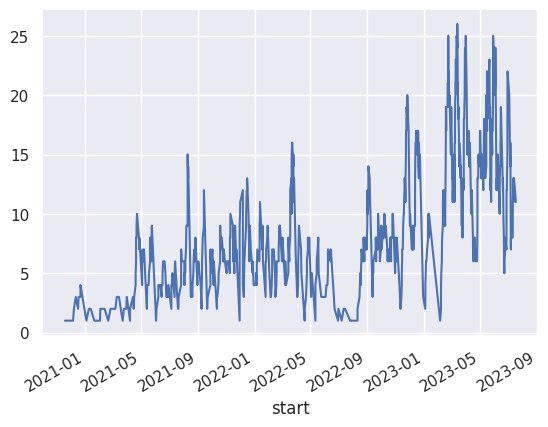

In [12]:
dfp.set_index('start').sort_index().rolling('7d')['id'].count().plot()

## VPP in test per recommendator

In [13]:
freqs = ['W-SUN', 'W-MON', 'W-TUE', 'W-WED', 'W-THU', 'W-SAT']
freq = freqs[0]

results = []
for freq in tqdm(freqs, leave=False):
    for dftrain, dftest, t, openproposals in timeFreqSplitCurrent(to_microsoft(dfv), freq, dfp.reset_index(), return_open=True, remove_not_in_train_col='userID'):
        dftrain_filter = dftrain[dftrain['itemID'].isin(openproposals)]
        
        results.append({
            'f': freq,
            't': t,
            # 'proposals in train': dftrain['itemID'].nunique(),
            # 'votes in train': len(dftrain),
            'votes in open proposals (train)': len(dftrain_filter),
            'users in open proposals (train)': dftrain_filter['userID'].nunique(),
            'open proposals': len(openproposals),
            'votes in test': len(dftest),
            'users in test': dftest['userID'].nunique(),
        })

res = pd.DataFrame(results)
res['vpp test'] = res['votes in test'] / res['open proposals']
res['vpu test'] = res['votes in test'] / res['users in test']
res.groupby('f').describe(percentiles=[]).T[freqs]

  0%|          | 0/6 [00:00<?, ?it/s]

f                                           W-SUN       W-MON       W-TUE  \
votes in open proposals (train) count  138.000000  138.000000  138.000000   
                                mean    25.608696   18.688406   31.572464   
                                std     34.623403   26.333571   37.921334   
                                min      0.000000    0.000000    0.000000   
                                50%     16.500000    2.000000   20.000000   
                                max    207.000000  130.000000  218.000000   
users in open proposals (train) count  138.000000  138.000000  138.000000   
                                mean    15.289855   12.507246   17.971014   
                                std     18.835517   18.085864   19.684349   
                                min      0.000000    0.000000    0.000000   
                                50%     10.000000    2.000000   15.000000   
                                max    108.000000  118.000000   86.000000   
open proposals                  count  138.000000  138.000000  138.000000   
                                mean     1.826087    1.311594    2.659420   
                                std      2.311233    1.867121    2.681367   
                                min      0.000000    0.000000    0.000000   
                                50%      1.000000    1.000000    2.000000   
                                max     10.000000   11.000000   17.000000   
votes in test                   count  138.000000  138.000000  138.000000   
                                mean    12.927536   12.710145   49.369565   
                                std     16.990610   26.121055   63.567434   
                                min      0.000000    0.000000    0.000000   
                                50%      5.000000    1.500000   28.500000   
                                max     74.000000  258.000000  457.000000   
users in test                   count  138.000000  138.000000  138.000000   
                                mean     8.884058    8.840580   24.318841   
                                std     11.678211   14.444076   24.016717   
                                min      0.000000    0.000000    0.000000   
                                50%      4.500000    1.000000   18.000000   
                                max     46.000000  113.000000   98.000000   
vpp test                        count   85.000000   73.000000  108.000000   
                                mean     8.986555   12.244953   20.388892   
                                std      9.381608   13.754618   16.235584   
                                min      0.000000    0.000000    1.000000   
                                50%      5.833333    7.000000   16.500000   
                                max     37.000000   86.000000   70.000000   
vpu test                        count   77.000000   72.000000  108.000000   
                                mean     1.474280    1.403495    1.863700   
                                std      0.557016    0.553610    0.919029   
                                min      1.000000    1.000000    1.000000   
                                50%      1.333333    1.123810    1.666667   
                                max      3.285714    4.000000    6.555556   

f                                           W-WED       W-THU       W-SAT  
votes in open proposals (train) count  138.000000  138.000000  138.000000  
                                mean    59.050725   78.000000   37.992754  
                                std     68.489791   91.509802   45.659402  
                                min      0.000000    0.000000    0.000000  
                                50%     41.000000   50.000000   25.500000  
                                max    424.000000  570.000000  266.000000  
users in open proposals (train) count  138.000000  138.000000  138.000000  
                                mean    28.094203   36.181159   25.079710  
    

In [14]:
res.groupby('f').sum().T[freqs]

/tmp/ipykernel_338452/4276310820.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  res.groupby('f').sum().T[freqs]


f,W-SUN,W-MON,W-TUE,W-WED,W-THU,W-SAT
votes in open proposals (train),3534.000000,2579.000000,4357.000000,8149.000000,10764.000000,5243.000000
users in open proposals (train),2110.000000,1726.000000,2480.000000,3877.000000,4993.000000,3461.000000
open proposals,252.000000,181.000000,367.000000,482.000000,515.000000,326.000000
votes in test,1784.000000,1754.000000,6813.000000,5632.000000,4731.000000,2672.000000
users in test,1226.000000,1220.000000,3356.000000,2813.000000,2780.000000,1641.000000
vpp test,763.857143,893.881602,2202.000350,1536.757323,1501.820671,1014.819336
vpu test,113.519588,101.051620,201.279557,216.450585,212.600374,159.887745


# Defining the baseline recommendator

Our baseline RecSys will be just recommending the top most famous proposals at time $t$.

In [15]:
from src.baseline import getBaselineRecommendations

"""
def getBaselineRecommendations(train: pd.DataFrame, users, k: int = 5, remove_train=True):
    bestVotes = train['itemID'].value_counts()
    df = pd.DataFrame(it.product(users, bestVotes.index), columns=['userID', 'itemID'])

    if remove_train:
        df = filter_by(df, train, ['userID', 'itemID'])
        
    df = df.groupby('userID').head(k).reset_index(drop=True)

    df['prediction'] = True
    return df
"""

# getBaselineRecommendations(folds[0][0], folds[0][1]['userID'].unique(), 3)

"\ndef getBaselineRecommendations(train: pd.DataFrame, users, k: int = 5, remove_train=True):\n    bestVotes = train['itemID'].value_counts()\n    df = pd.DataFrame(it.product(users, bestVotes.index), columns=['userID', 'itemID'])\n\n    if remove_train:\n        df = filter_by(df, train, ['userID', 'itemID'])\n        \n    df = df.groupby('userID').head(k).reset_index(drop=True)\n\n    df['prediction'] = True\n    return df\n"

# Evaluating the baseline recommendator with `timeIntervalSplit`

In [16]:
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k

In [17]:
def check_train_recs(df, filter_by_df, filter_by_cols):
    return any(df.set_index(filter_by_cols).index.isin(
        filter_by_df.set_index(filter_by_cols).index
    ))

In [18]:
from collections import defaultdict

folds = list(timeIntervalSplit(df, N_SPLITS, skip=SKIP_SPLIT, remove_not_in_train_col='userID'))
metrics_f = { 'precision':precision_at_k, 'ndcg': ndcg_at_k, 'ndcg': ndcg_at_k, 'map': map_at_k, 'recall': recall_at_k, }
# metrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
# perfectmetrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
metrics = defaultdict(list)
perfectmetrics = defaultdict(list)

for i, (train, test) in enumerate(folds):
    t = train.timestamp.max()
    print(f"===== Training on fold {i} (t: {t})  =====")
    # print(f"Ratings train: {len(train)}, test: {len(test)}")

    open_proposals = dfp[(dfp['start'] < t) & (t < dfp['end']) ]['id'].unique()
    print(f"Currently open proposals: {len(open_proposals)}")

    train_filtered = train[train['itemID'].isin(open_proposals) ]
    test_filtered = test[test['itemID'].isin(open_proposals) ]
    print(f"Train votes in open proposals: {len(train_filtered):3}")
    print(f"Test votes in open proposals:  {len(test_filtered):3}")    

    # print('Tested score:')
    for k_recs in K_RECOMMENDATIONS:
        recs = getBaselineRecommendations(train, test_filtered['userID'].unique(), open_proposals, k_recs)
    
        if check_train_recs(recs, train_filtered, ['userID', 'itemID']):
            print("There are recommendations that were true in training")
            assert False
        
        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            metrics[m+f'@{k_recs}'].append(r)
            
        # print('Perfect predictor score:')
        recs = test_filtered.copy()
        recs['prediction'] = True
        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            perfectmetrics[m+f'@{k_recs}'].append(r)
    
    print()

===== Training on fold 0 (t: 2021-02-13 20:35:46)  =====
Currently open proposals: 1
Train votes in open proposals:  36
Test votes in open proposals:    0

===== Training on fold 1 (t: 2021-05-14 17:31:38)  =====
Currently open proposals: 3
Train votes in open proposals:  30
Test votes in open proposals:  117

===== Training on fold 2 (t: 2021-08-11 03:15:01)  =====
Currently open proposals: 9
Train votes in open proposals: 270
Test votes in open proposals:  182



===== Training on fold 3 (t: 2021-11-07 10:45:33)  =====
Currently open proposals: 2
Train votes in open proposals:  62
Test votes in open proposals:   25

===== Training on fold 4 (t: 2022-02-04 00:20:30)  =====
Currently open proposals: 1
Train votes in open proposals:  53
Test votes in open proposals:    6



===== Training on fold 5 (t: 2022-05-03 10:44:21)  =====
Currently open proposals: 2
Train votes in open proposals:  38
Test votes in open proposals:   49



===== Training on fold 6 (t: 2022-07-28 17:51:11)  =====
Currently open proposals: 1
Train votes in open proposals:  35
Test votes in open proposals:    0

===== Training on fold 7 (t: 2022-10-27 07:28:56)  =====
Currently open proposals: 6
Train votes in open proposals: 153
Test votes in open proposals:   19



===== Training on fold 8 (t: 2023-01-13 20:44:31)  =====
Currently open proposals: 2
Train votes in open proposals:  37
Test votes in open proposals:    0

===== Training on fold 9 (t: 2023-04-22 01:42:11)  =====
Currently open proposals: 5
Train votes in open proposals:  58
Test votes in open proposals:    8


In [19]:
# from src import paths

# Won't even save it because its not used
# pd.DataFrame(metrics).to_csv(paths.baseline_mp(ORG_NAME, N_SPLITS), index=False)

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,perfect precision@5,perfect precision@10
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.231037,0.567361,0.529839,0.632770,0.133572,0.591637,0.551816,0.700000,0.089048,0.591637,0.551816,0.700000,0.257911,0.133572
std,0.176371,0.431049,0.421771,0.470100,0.105475,0.426657,0.416236,0.483046,0.070316,0.426657,0.416236,0.483046,0.198763,0.105475
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.050000,0.087617,0.061292,0.106924,0.025000,0.138021,0.098377,0.250000,0.016667,0.138021,0.098377,0.250000,0.050000,0.025000
50%,0.264976,0.790798,0.705779,0.950000,0.151111,0.811367,0.741493,1.000000,0.100741,0.811367,0.741493,1.000000,0.302222,0.151111
75%,0.379124,0.910783,0.877083,1.000000,0.199576,0.910783,0.877083,1.000000,0.133051,0.910783,0.877083,1.000000,0.399153,0.199576
max,0.457143,1.000000,1.000000,1.000000,0.271429,1.000000,1.000000,1.000000,0.180952,1.000000,1.000000,1.000000,0.514286,0.271429


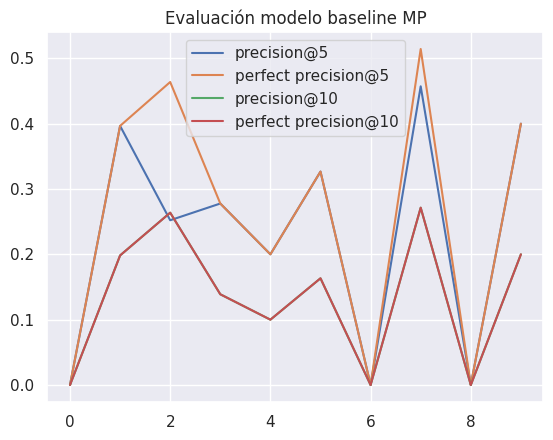

In [20]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = perfectmetrics['precision@5']
mdf['perfect precision@10'] = perfectmetrics['precision@10']
mdf[['precision@5', 'perfect precision@5', 'precision@10', 'perfect precision@10']].plot(title='Evaluación modelo baseline MP')
mdf.describe()

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.257911,0.700000,0.693915,0.693915,0.133572,0.700000,0.700000,0.700000,0.089048,0.700000,0.700000,0.700000
std,0.198763,0.483046,0.479011,0.479011,0.105475,0.483046,0.483046,0.483046,0.070316,0.483046,0.483046,0.483046
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.050000,0.250000,0.240741,0.240741,0.025000,0.250000,0.250000,0.250000,0.016667,0.250000,0.250000,0.250000
50%,0.302222,1.000000,0.988095,0.988095,0.151111,1.000000,1.000000,1.000000,0.100741,1.000000,1.000000,1.000000
75%,0.399153,1.000000,1.000000,1.000000,0.199576,1.000000,1.000000,1.000000,0.133051,1.000000,1.000000,1.000000
max,0.514286,1.000000,1.000000,1.000000,0.271429,1.000000,1.000000,1.000000,0.180952,1.000000,1.000000,1.000000


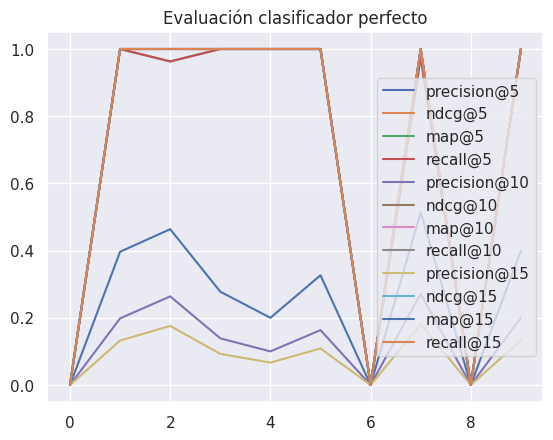

In [21]:
pmdf = pd.DataFrame(perfectmetrics)
pmdf.plot(title='Evaluación clasificador perfecto')
pmdf.describe()

# Evaluation the baseline recommendator with `timeFreqSplit`

In [22]:
from tqdm.autonotebook import tqdm

In [23]:
from functools import partial
import sys

folds = list(timeFreqSplitCurrent(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE))
metrics_f = { 'precision':precision_at_k, 'ndcg': ndcg_at_k, 'ndcg': ndcg_at_k, 'map': map_at_k, 'recall': recall_at_k, }
# metrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
metrics = defaultdict(list)
perfectmetrics = defaultdict(list)

for i, (train, test) in enumerate(tqdm(folds)):
    t = train.timestamp.max()

    assert not train.empty, f"Train should not be empty on fold {i}"
    # assert not test.empty, f"Test should not be empty on fold {i}"
    if test.empty:
        print(f"Warning, empty test fold {i}", file=sys.stderr)
    # print(f"===== Training on fold {i} (t: {t})  =====")
    # print(f"Ratings train: {len(train)}, test: {len(test)}")

    open_proposals = dfp[(dfp['start'] < t) & (t < dfp['end']) ]['id'].unique()
    # print(f"Currently open proposals: {len(open_proposals)}")

    train_filtered = train[train['itemID'].isin(open_proposals) ]
    test_filtered = test[test['itemID'].isin(open_proposals) ]
    # print(f"Train votes in open proposals: {len(train_filtered):3}")
    # print(f"Test votes in open proposals:  {len(test_filtered):3}")    

    # print('Tested score:')
    metrics['t'].append(t)
    perfectmetrics['t'].append(t)
    for k_recs in K_RECOMMENDATIONS:
        recs = getBaselineRecommendations(train, test_filtered['userID'].unique(), open_proposals, k_recs)
    
        if check_train_recs(recs, train_filtered, ['userID', 'itemID']):
            print("There are recommendations that were true in training")
            assert False

        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            metrics[m+f'@{k_recs}'].append(r)
            
        # print('Perfect predictor score:')
        recs = test_filtered.copy()
        recs['prediction'] = True
        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            perfectmetrics[m+f'@{k_recs}'].append(r)
    
    # print()

  0%|          | 0/138 [00:00<?, ?it/s]

Warning, empty test fold 0
Warning, empty test fold 1
Warning, empty test fold 2


Warning, empty test fold 5
Warning, empty test fold 6
Warning, empty test fold 7


Warning, empty test fold 10


Warning, empty test fold 13


Warning, empty test fold 17


Warning, empty test fold 74


Warning, empty test fold 85


Warning, empty test fold 87


Warning, empty test fold 89


Warning, empty test fold 94


Warning, empty test fold 113
Warning, empty test fold 114


Warning, empty test fold 115


In [24]:
print(df['timestamp'].min(), df['timestamp'].max())
_folds = list(timeFreqSplitCurrent(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE, inclusive='right', return_open=True))
_, _, t, _ = _folds[0]
print("t0:", t)
_, _, t, _ = _folds[1]
print("t1:", t)
_, _, t, _ = _folds[-2]
print("t-2:", t)
_, _, t, _ = _folds[-1]
print("t-1:", t)

2020-11-18 20:56:32 2023-07-19 14:30:54


t0: 2020-11-19 00:00:00
t1: 2020-11-26 00:00:00
t-2: 2023-06-29 00:00:00
t-1: 2023-07-06 00:00:00


In [25]:
{ k:len(v) for k,v in metrics.items() }

{'t': 138,
 'precision@5': 138,
 'ndcg@5': 138,
 'map@5': 138,
 'recall@5': 138,
 'precision@10': 138,
 'ndcg@10': 138,
 'map@10': 138,
 'recall@10': 138,
 'precision@15': 138,
 'ndcg@15': 138,
 'map@15': 138,
 'recall@15': 138}

In [26]:
display(dfp['date'].min())
display(df['timestamp'].min())
display(df.sort_values('timestamp').head())
display(dfp.sort_values('date').head())

Timestamp('2020-11-18 20:51:14')

Timestamp('2020-11-18 20:56:32')

,userID,itemID,timestamp,rating
9824,0xf3862af14cbb4d9b781e41a3d4d74e7c2cdb73e2,e03585d8-6ab1-52d0-8d05-6b20a2f457b9,2020-11-18 20:56:32,1
9823,0xba71dfe1801d125ba201e8bebf7f0b9764d4b19b,e03585d8-6ab1-52d0-8d05-6b20a2f457b9,2020-11-18 21:23:13,1
9822,0x042a135bd342910ad7f67bbda74e3fd4125d1272,e03585d8-6ab1-52d0-8d05-6b20a2f457b9,2020-11-18 21:23:55,1
9821,0x21f3ef56cd8bafd9448515e4508077c16ecc1f35,e03585d8-6ab1-52d0-8d05-6b20a2f457b9,2020-11-18 21:42:37,1
9820,0x506f92308f4d9a2f764d80c68ebc50830a2f7a11,e03585d8-6ab1-52d0-8d05-6b20a2f457b9,2020-11-18 21:45:10,1


,platform,name,platform_deployment,id,deployment,platform_proposal,author,date,votes_count,title,description,start,end
138,snapshot,Index Coop,index-coop.eth,e03585d8-6ab1-52d0-8d05-6b20a2f457b9,17dba91a-e68f-50f6-8c1d-2d7fa57ab5fb,QmR8dNJPcZTcmSP5g86iaGUiArs9DeYTEZkSf7Dg2hVavS,0xf3862af14cbb4d9b781e41a3d4d74e7c2cdb73e2,2020-11-18 20:51:14,46,[AAVE-1] Upgrades for seamless transition to A...,This proposal is for voting on Aave's proposal...,2020-11-18 16:00:00,2020-11-21 08:28:00
137,snapshot,Index Coop,index-coop.eth,eba9b4f9-ad65-5bb3-8e14-7ac51c6c3634,17dba91a-e68f-50f6-8c1d-2d7fa57ab5fb,QmRw6FoXJRhm4WLaWVuRgsXhE7ZfWvAKY42E386ksugfUC,0xc95fdee19b74bc9588f4888fb0762e83cfef5d45,2020-12-06 06:10:07,82,[COMPOUND-30] COMP Contributor Grants,This proposal is for voting on Compound's prop...,2020-12-05 23:13:19,2020-12-08 19:32:10
136,snapshot,Index Coop,index-coop.eth,cc55a2f4-e982-544d-ba72-22913ed4e1ab,17dba91a-e68f-50f6-8c1d-2d7fa57ab5fb,QmTdYHoyT5eLWSZduHkivVxs3Vree1EUQUYCk8uoW4Q1EA,0xc95fdee19b74bc9588f4888fb0762e83cfef5d45,2020-12-07 21:50:10,45,[COMPOUND-31] Adjusting Reserve Factors,This proposal is for voting on Compound's prop...,2020-12-07 21:48:18,2020-12-10 21:47:41
135,snapshot,Index Coop,index-coop.eth,36cb30a7-7532-598a-87f8-07c204455bd5,17dba91a-e68f-50f6-8c1d-2d7fa57ab5fb,QmethJXKnCMd89wWBaxCBRcK2Hu8Dhx5E5AM7XeHEKsL1n,0xc95fdee19b74bc9588f4888fb0762e83cfef5d45,2020-12-11 21:20:11,77,[COMPOUND-32] Distribute COMP to Affected User...,This proposal is for voting on Compound's prop...,2020-12-11 21:17:20,2020-12-14 21:13:36
134,snapshot,Index Coop,index-coop.eth,0bcf5b7b-c874-51ce-974b-b8b098ce6409,17dba91a-e68f-50f6-8c1d-2d7fa57ab5fb,QmSSZzLPbLpegBWfxPBTVAdvUZoXAL2V6Hi58YHEi6bemW,0x5dd5fc8761fe933bc58e5ab5be062dd836dfa801,2020-12-16 02:13:40,93,IIP-7 CoinShares Gold and Cryptoassets Index L...,## Simple Summary\n\nThe CoinShares Gold and C...,2020-12-16 20:00:00,2020-12-19 20:00:00


In [27]:
# Save the data
from pathlib import Path
from src.baseline import write_metrics_baseline

# pd.DataFrame(metrics).set_index('t').to_csv(paths.baseline_mp_freq(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE))
write_metrics_baseline(pd.DataFrame(metrics).set_index('t'), ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,perfect precision@5,perfect precision@10,perfect map@10
count,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000
mean,0.256551,0.669507,0.614896,0.783997,0.142889,0.688180,0.631745,0.833445,0.096801,0.690932,0.633103,0.841298,0.294224,0.152086,0.869482
std,0.139903,0.329444,0.337039,0.361923,0.083937,0.320396,0.327542,0.348193,0.057327,0.317686,0.325987,0.345186,0.170547,0.093661,0.337977
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.200000,0.536313,0.424402,0.668203,0.100000,0.596092,0.454691,1.000000,0.066667,0.599199,0.467458,1.000000,0.200000,0.100000,1.000000
50%,0.257143,0.775748,0.692122,1.000000,0.142206,0.782570,0.706493,1.000000,0.095974,0.782570,0.706493,1.000000,0.285584,0.143961,1.000000
75%,0.328095,0.918718,0.887837,1.000000,0.186269,0.918718,0.887837,1.000000,0.125694,0.918718,0.887837,1.000000,0.392653,0.200000,1.000000
max,0.580000,1.000000,1.000000,1.000000,0.525000,1.000000,1.000000,1.000000,0.350000,1.000000,1.000000,1.000000,0.825000,0.525000,1.000000


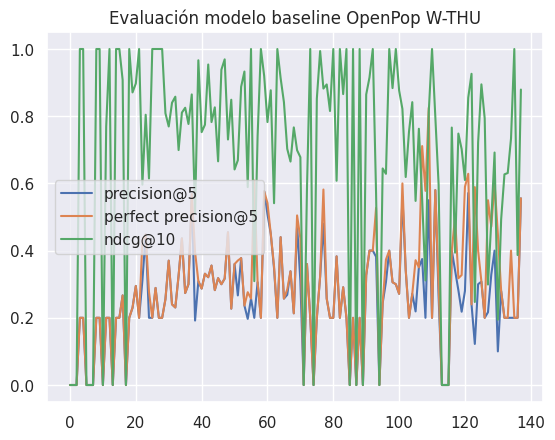

In [28]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = perfectmetrics['precision@5']
mdf['perfect precision@10'] = perfectmetrics['precision@10']
mdf['perfect map@10'] = perfectmetrics['map@10']
mdf[['precision@5', 'perfect precision@5', 'ndcg@10']].plot(title=f'Evaluación modelo baseline OpenPop {SPLITS_FREQ}')
mdf.describe()

In [29]:
mdf[-LAST_SPLITS:].describe()

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,perfect precision@5,perfect precision@10,perfect map@10
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0
mean,0.266413,0.578565,0.470800,0.810542,0.163230,0.612453,0.501750,0.898295,0.116320,0.625732,0.508018,0.935448,0.355698,0.189659,1.0
std,0.131337,0.249765,0.282368,0.305715,0.081525,0.235403,0.272861,0.209826,0.055602,0.211742,0.263485,0.117329,0.158666,0.091073,0.0
min,0.100000,0.103802,0.049306,0.055556,0.100000,0.194161,0.112517,0.364583,0.066667,0.326948,0.175201,0.701701,0.200000,0.100000,1.0
25%,0.200000,0.473078,0.319330,0.687143,0.100000,0.488909,0.333619,0.937500,0.066667,0.488909,0.333619,0.937500,0.200000,0.100000,1.0
50%,0.200000,0.587040,0.458067,1.000000,0.132500,0.628953,0.500000,1.000000,0.102222,0.628953,0.500000,1.000000,0.340000,0.178333,1.0
75%,0.316429,0.646177,0.554167,1.000000,0.186310,0.723381,0.616748,1.000000,0.150893,0.723381,0.616748,1.000000,0.466071,0.270536,1.0
max,0.555556,1.000000,1.000000,1.000000,0.330000,1.000000,1.000000,1.000000,0.220000,1.000000,1.000000,1.000000,0.600000,0.330000,1.0


,t,model,variable,value
0,2020-11-18 23:44:52,openpop,precision@5,0.000000
1,2020-11-20 23:05:39,openpop,precision@5,0.000000
2,2020-11-20 23:05:39,openpop,precision@5,0.000000
3,2020-12-09 23:29:57,openpop,precision@5,0.200000
4,2020-12-16 23:06:49,openpop,precision@5,0.200000
...,...,...,...,...
547,2023-06-07 15:31:44,perfect,recall@5,1.000000
548,2023-06-14 18:52:50,perfect,recall@5,0.972222
549,2023-06-21 15:30:18,perfect,recall@5,1.000000
550,2023-06-28 19:33:35,perfect,recall@5,1.000000


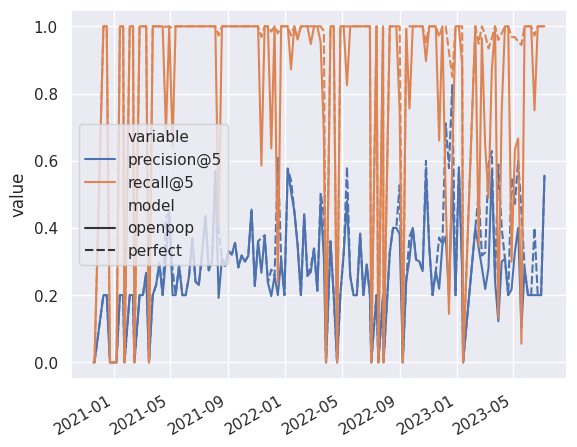

In [30]:
_METRICS = ['precision@5', 'recall@5']

_toplot = pd.concat([
    pd.DataFrame(metrics).assign(model='openpop'),
    pd.DataFrame(perfectmetrics).assign(model='perfect')
])
_toplot = _toplot[['t', 'model'] + _METRICS].melt(id_vars=['t', 'model'])
display(_toplot)

sns.lineplot(_toplot, x='t', y='value', hue='variable', style='model')
plt.xlabel("")
plt.xticks(rotation=30, ha='right');

In [31]:
def _plot_metric(metric):
    _toplot = pd.concat([
        pd.DataFrame(metrics).assign(model='openpop'),
        pd.DataFrame(perfectmetrics).assign(model='perfect')
    ])

    display(_toplot)
    ax = sns.lineplot(_toplot, x='t', y=metric, style='model')
    plt.xlabel("")
    plt.xticks(rotation=30, ha='right');
    return ax

nbutils.download_matplotlib(ax.figure, f'10_all_precision@5_{SPLITS_FREQ}_{SPLITS_NORMALIZE}_{ORG_NAME}.pdf')

Cannot show ipywidgets in text

,t,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,model
0,2020-11-18 23:44:52,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,openpop
1,2020-11-20 23:05:39,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,openpop
2,2020-11-20 23:05:39,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,openpop
3,2020-12-09 23:29:57,0.200000,1.0,1.000000,1.000000,0.100000,1.0,1.0,1.0,0.066667,1.0,1.0,1.0,openpop
4,2020-12-16 23:06:49,0.200000,1.0,1.000000,1.000000,0.100000,1.0,1.0,1.0,0.066667,1.0,1.0,1.0,openpop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,2023-06-07 15:31:44,0.200000,1.0,1.000000,1.000000,0.100000,1.0,1.0,1.0,0.066667,1.0,1.0,1.0,perfect
134,2023-06-14 18:52:50,0.400000,1.0,0.972222,0.972222,0.216667,1.0,1.0,1.0,0.144444,1.0,1.0,1.0,perfect
135,2023-06-21 15:30:18,0.200000,1.0,1.000000,1.000000,0.100000,1.0,1.0,1.0,0.066667,1.0,1.0,1.0,perfect
136,2023-06-28 19:33:35,0.200000,1.0,1.000000,1.000000,0.100000,1.0,1.0,1.0,0.066667,1.0,1.0,1.0,perfect


Cannot show ipywidgets in text

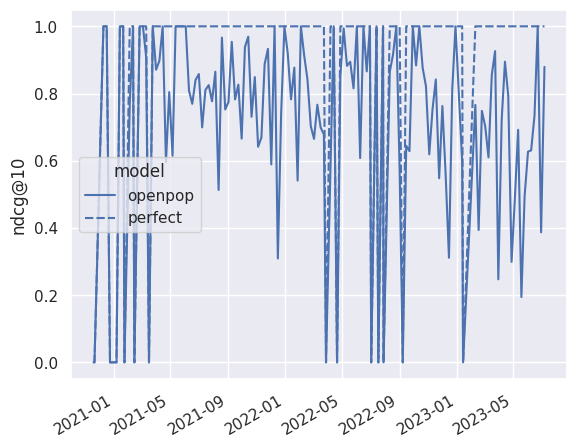

In [32]:
ax = _plot_metric('ndcg@10')
nbutils.download_matplotlib(ax.figure, f'10_all_ndcg@10_{SPLITS_FREQ}_{SPLITS_NORMALIZE}_{ORG_NAME}.pdf')

In [33]:
pmdf

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15
0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.396610,1.0,1.000000,1.000000,0.198305,1.0,1.0,1.0,0.132203,1.0,1.0,1.0
2,0.463768,1.0,0.962963,0.962963,0.263768,1.0,1.0,1.0,0.175845,1.0,1.0,1.0
3,0.277778,1.0,1.000000,1.000000,0.138889,1.0,1.0,1.0,0.092593,1.0,1.0,1.0
4,0.200000,1.0,1.000000,1.000000,0.100000,1.0,1.0,1.0,0.066667,1.0,1.0,1.0
5,0.326667,1.0,1.000000,1.000000,0.163333,1.0,1.0,1.0,0.108889,1.0,1.0,1.0
6,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
7,0.514286,1.0,0.976190,0.976190,0.271429,1.0,1.0,1.0,0.180952,1.0,1.0,1.0
8,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
9,0.400000,1.0,1.000000,1.000000,0.200000,1.0,1.0,1.0,0.133333,1.0,1.0,1.0


,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15
count,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000
mean,0.294224,0.869565,0.862836,0.862836,0.152086,0.869565,0.869482,0.869482,0.101452,0.869565,0.869565,0.869565
std,0.170547,0.338008,0.335919,0.335919,0.093661,0.338008,0.337977,0.337977,0.062561,0.338008,0.338008,0.338008
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.200000,1.000000,0.973098,0.973098,0.100000,1.000000,1.000000,1.000000,0.066667,1.000000,1.000000,1.000000
50%,0.285584,1.000000,1.000000,1.000000,0.143961,1.000000,1.000000,1.000000,0.095974,1.000000,1.000000,1.000000
75%,0.392653,1.000000,1.000000,1.000000,0.200000,1.000000,1.000000,1.000000,0.133333,1.000000,1.000000,1.000000
max,0.825000,1.000000,1.000000,1.000000,0.525000,1.000000,1.000000,1.000000,0.350000,1.000000,1.000000,1.000000


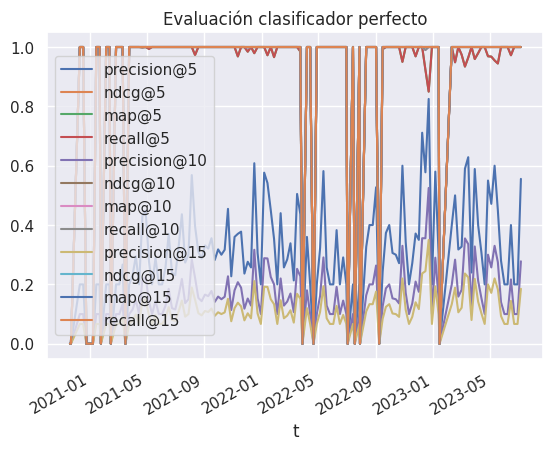

In [34]:
from src.baseline import write_metrics_perfect

pmdf = pd.DataFrame(perfectmetrics).set_index('t')

# pmdf.to_csv(paths.perfect_mp_freq(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE))
write_metrics_perfect(pmdf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
pmdf.plot(title='Evaluación clasificador perfecto')
pmdf.describe()

## Exploring the folds

In [35]:
print(f"There are {len(folds)} folds")
print(f"From {df['timestamp'].min()} to {df['timestamp'].max()}")

full_len = len(df)
fold_len = []
for tr, ts, t, open_proposals in timeFreqSplitCurrent(df, SPLITS_FREQ, dfp, return_open=True, normalize=SPLITS_NORMALIZE):
    fold_len.append({
        't': t,
        'train': len(tr),
        'test': len(ts),
        'open': len(open_proposals),
        'test users': ts['userID'].nunique(),
        'test vpv': ts['userID'].nunique() / len(ts) if len(ts) else np.NaN,
        'test vpp': ts['userID'].nunique() / ts['itemID'].nunique() if len(ts) else np.NaN,
        # 't_train_min': tr['timestamp'].min(),
        # 't_train_max': tr['timestamp'].max(),
        't_test_min': ts['timestamp'].min(),
        't_test_max': ts['timestamp'].max(),
    })

fold_len = pd.DataFrame(fold_len)
fold_len.describe()

There are 138 folds
From 2020-11-18 20:56:32 to 2023-07-19 14:30:54


,train,test,open,test users,test vpv,test vpp
count,138.000000,138.000000,138.000000,138.000000,122.000000,122.000000
mean,13747.101449,38.862319,3.731884,23.746377,0.668926,11.313183
std,7433.559695,43.964018,3.211612,27.921439,0.235842,17.159259
min,11.000000,0.000000,0.000000,0.000000,0.263158,0.500000
25%,7796.500000,9.000000,1.000000,7.250000,0.472259,3.000000
50%,16060.500000,28.000000,3.000000,16.000000,0.648352,4.583333
75%,19599.500000,53.750000,5.000000,27.000000,0.861830,10.750000
max,23954.000000,303.000000,16.000000,184.000000,1.000000,115.000000


In [36]:
fold_len

,t,train,test,open,test users,test vpv,test vpp,t_test_min,t_test_max
0,2020-11-19,11,35,1,35,1.000000,35.000000,2020-11-19 00:25:26,2020-11-20 23:05:39
1,2020-11-26,46,0,0,0,NaN,NaN,NaT,NaT
2,2020-12-03,46,0,0,0,NaN,NaN,NaT,NaT
3,2020-12-10,164,9,1,9,1.000000,9.000000,2020-12-10 00:47:09,2020-12-10 21:28:51
4,2020-12-17,269,74,1,74,1.000000,74.000000,2020-12-17 00:33:37,2020-12-19 19:30:00
...,...,...,...,...,...,...,...,...,...
133,2023-06-08,23744,7,3,6,0.857143,2.000000,2023-06-08 04:37:49,2023-06-09 17:06:28
134,2023-06-15,23801,18,10,6,0.333333,0.666667,2023-06-15 00:18:26,2023-06-16 21:08:56
135,2023-06-22,23847,9,2,7,0.777778,3.500000,2023-06-22 00:20:53,2023-06-23 09:34:17
136,2023-06-29,23908,8,10,7,0.875000,1.750000,2023-06-29 00:06:03,2023-07-01 00:10:50


In [37]:
# Get folds with more than 10 open proposals
MIN_OPEN = 10
MIN_USERS = 5
MIN_VPP = 1

MIN_FOLDS = 10

# fold_len['min_open'] = (fold_len['open'] >= MIN_OPEN) & (fold_len['test users'] >= MIN_USERS)
fold_len['min'] = (fold_len['test vpp'] >= MIN_VPP)
print("There are", fold_len['min'].sum(), "folds that could be used")
fold_len['min_window'] = fold_len.rolling(MIN_FOLDS)['min'].sum() >= MIN_FOLDS
fold_len[fold_len['min_window']].tail(20)

There are 119 folds that could be used


,t,train,test,open,test users,test vpv,test vpp,t_test_min,t_test_max,min,min_window
66,2022-02-24,15742,58,6,42,0.724138,7.000000,2022-02-24 03:18:18,2022-02-26 17:57:35,True,True
67,2022-03-03,15868,46,4,28,0.608696,7.000000,2022-03-03 04:15:01,2022-03-07 20:33:03,True,True
68,2022-03-10,15980,17,3,16,0.941176,8.000000,2022-03-10 00:51:16,2022-03-12 19:08:45,True,True
69,2022-03-17,16141,54,6,22,0.407407,3.666667,2022-03-17 00:41:03,2022-03-19 13:27:23,True,True
70,2022-03-24,16491,25,7,11,0.440000,1.571429,2022-03-24 00:17:29,2022-03-24 17:36:23,True,True
71,2022-03-31,16559,16,1,16,1.000000,16.000000,2022-03-31 08:40:21,2022-04-01 19:46:41,True,True
72,2022-04-07,16782,29,6,16,0.551724,2.666667,2022-04-07 00:35:19,2022-04-10 13:34:27,True,True
73,2022-04-14,16865,8,1,8,1.000000,8.000000,2022-04-14 00:18:25,2022-04-14 17:03:27,True,True
84,2022-06-30,17834,25,1,25,1.000000,25.000000,2022-06-30 01:05:44,2022-07-02 12:37:18,True,True
107,2022-12-08,20061,32,5,9,0.281250,1.800000,2022-12-08 02:07:13,2022-12-09 16:08:49,True,True


            train  test  i
t                         
2020-11-19     11    35  0
2020-11-26     46     0  1
2020-12-03     46     0  2
2020-12-10    164     9  3
2020-12-17    269    74  4
2020-12-24    457     0  5
2020-12-31    457     0  6
2021-01-07    515     0  7
2021-01-14    553    32  8
2021-01-21    593    33  9


Cannot show ipywidgets in text

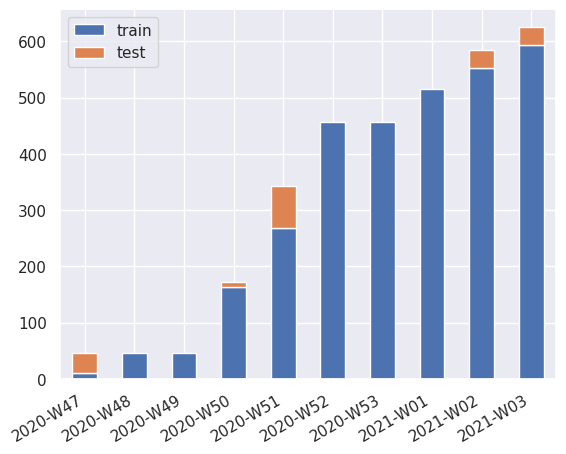

In [38]:
FIRST_FOLDS = 10
LAST_FOLDS = 0

# Bosquejo usando pandas.plot
_toplot = fold_len.set_index('t')[['train', 'test']]
_toplot['i'] = fold_len.index

_toplot = _toplot[ (_toplot['i'] < FIRST_FOLDS) | (_toplot['i'] > (len(_toplot) - LAST_FOLDS)) ]

print(_toplot)
ax = _toplot[['train', 'test']].plot.bar(stacked=True)
ax.set_xticks(np.arange(10), _toplot.index.strftime('%G-W%V'), rotation=30, ha='right')
ax.set_xlabel("")

nbutils.download_matplotlib(ax.figure, f'10_first_folds_{SPLITS_FREQ}_{SPLITS_NORMALIZE}_{ORG_NAME}.pdf')

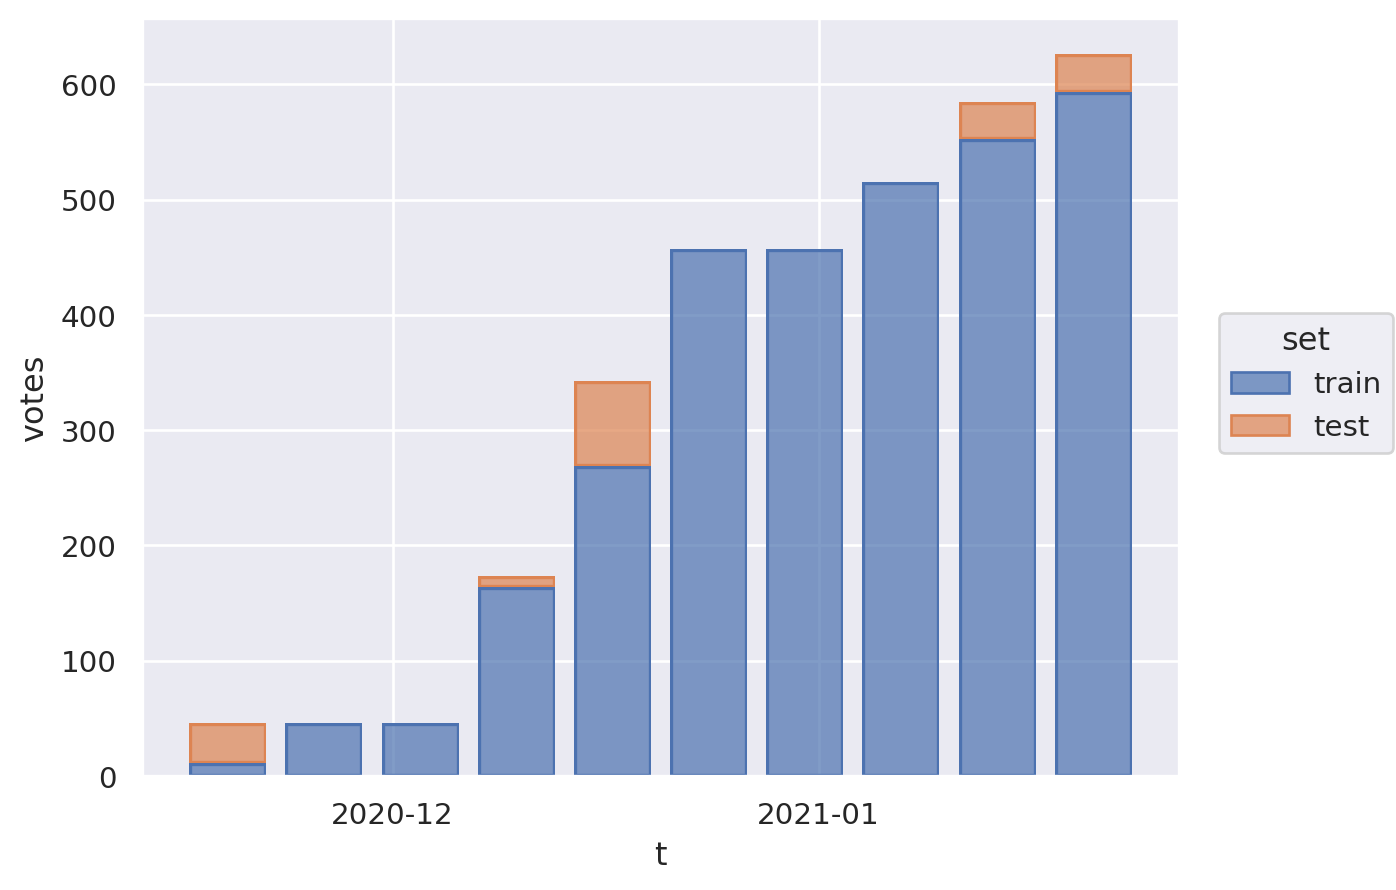

In [39]:
# Definitivo en seaborn
import seaborn.objects as so

_toplot = fold_len.assign(i=fold_len.index).melt(id_vars=['t', 'i'], value_vars=['train', 'test'], var_name='set', value_name='votes')
_toplot = _toplot[_toplot['i'] < FIRST_FOLDS]
so.Plot(_toplot, x='t', y='votes', color='set').add(so.Bar(), so.Stack())